In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.distributions import Categorical, Normal, MixtureSameFamily
from torch.optim.swa_utils import AveragedModel, SWALR

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from datamodel import SPX, StockData
from model_testing import Model, WalkForwardAnalysis, create_lags
plt.rcParams["figure.figsize"] = (15,10)

In [9]:
class ARMLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ELU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, out_dim)
        )
    
    def forward(self, x):
        return self.network(x)

In [34]:
class ARMLPModel(Model):
    def __init__(self, in_dim, out_dim, hidden_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim
        self.scaler = StandardScaler()
        self.mseloss = nn.MSELoss()
        
    def fit(self, train_indep_var, train_dep_var):
        self.model = ARMLP(self.in_dim, self.out_dim, self.hidden_dim)
        optim = torch.optim.Adam(self.model.parameters())
        
        self.scaler.fit(train_indep_var)
        indep_var_tensor = torch.tensor(self.scaler.transform(train_indep_var), dtype=torch.float32)
        dep_var_tensor = torch.tensor(train_dep_var, dtype=torch.float32).reshape(-1, 1)
        
        self.model.train()
        for epoch in range(1000):
            optim.zero_grad()
            output = self.model(indep_var_tensor)
            loss = self.mseloss(output, dep_var_tensor)
            loss.backward()
            optim.step()
        
    def loss(self, test_indep_var, test_dep_var):
        indep_var_tensor = torch.tensor(self.scaler.transform(test_indep_var), dtype=torch.float32)
        dep_var_tensor = torch.tensor(test_dep_var, dtype=torch.float32).reshape(-1, 1)
        
        self.model.eval()
        output = self.model(indep_var_tensor)
        predicted = pd.Series(output.detach().squeeze().numpy(), index=test_indep_var.index)
        result = {"predicted": predicted,
                  "r2": r2_score(test_dep_var, predicted),
                  "residuals": test_dep_var - predicted}
        return result

In [4]:
spx = SPX()
data = StockData(["^VIX"])

spx_wk_prices = spx.prices.resample("W-FRI").last()
spx_wk_returns = (np.log(spx_wk_prices) - np.log(spx_wk_prices.shift(1))).dropna()
spx_wk_vol = np.sqrt(spx.vol.resample("W-FRI").sum())

In [5]:
spx_vol_lags = create_lags(np.log(np.sqrt(spx.vol)), 21, "spx_vol")
vix_lags = create_lags(np.log(data.prices.VIX["close"]), 21, "vix")
spx_return_lags = create_lags(spx.returns, 21, "spx_returns")

indep_var = pd.concat([spx_vol_lags, vix_lags, spx_return_lags], axis=1).dropna()
dep_var = np.log(spx_wk_vol.shift(-1).dropna())

common_index = indep_var.index.intersection(dep_var.index)

indep_var = indep_var.loc[common_index]
dep_var = dep_var.loc[common_index]

In [35]:
model = ARMLPModel(len(indep_var.columns), 1, 25)
model_test = WalkForwardAnalysis(indep_var, dep_var, model, splits=25, min_samples=52)
results = model_test.walk_forward_test()

predicted = pd.concat([n["predicted"] for n in results])
r2 = [n["r2"] for n in results]
residuals = pd.concat([n["residuals"] for n in results])

Split 0 complete.
Split 1 complete.
Split 2 complete.
Split 3 complete.
Split 4 complete.
Split 5 complete.
Split 6 complete.
Split 7 complete.
Split 8 complete.
Split 9 complete.
Split 10 complete.
Split 11 complete.
Split 12 complete.
Split 13 complete.
Split 14 complete.
Split 15 complete.
Split 16 complete.
Split 17 complete.
Split 18 complete.
Split 19 complete.
Split 20 complete.
Split 21 complete.
Split 22 complete.
Split 23 complete.


<AxesSubplot:>

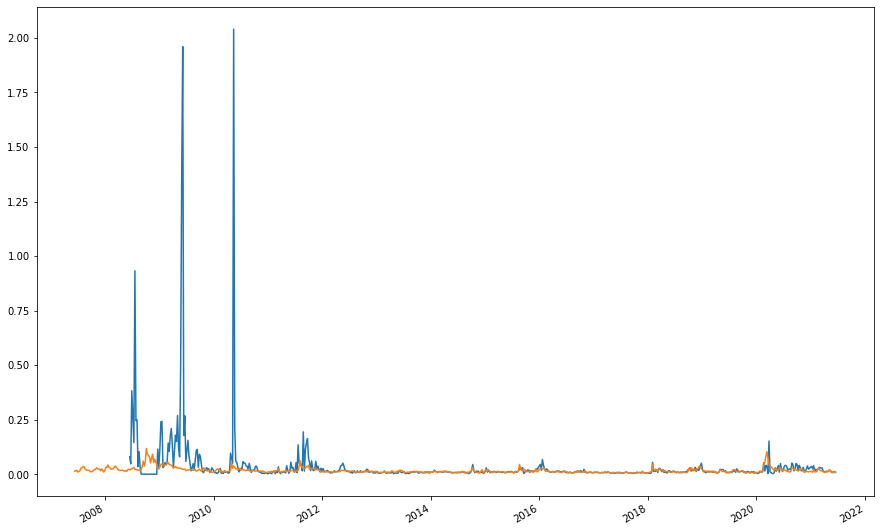

In [36]:
np.exp(predicted).plot()
np.exp(dep_var).plot()